# Dynamics of Software Development and Archiving

## Import libraries

In [1]:
import datetime
import json

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd

## Load data

In [2]:
df = pd.read_csv("../results/articles_info_pubmed_github_software_heritage.tsv", sep="\t", index_col="PMID")
df.iloc[0,]

publication_date                                            2010-12-17
DOI                                      10.1093/bioinformatics/btq693
journal                               Bioinformatics (Oxford, England)
title                SAIL--a software system for sample and phenoty...
abstract             The Sample avAILability system-SAIL-is a web b...
GitHub_link_raw                                       github.com/sail.
GitHub_link_clean                             https://github.com/sail/
GitHub_repo_owner                                                 sail
GitHub_repo_name                                                   NaN
date_repo_created                                                  NaN
date_repo_updated                                                  NaN
is_fork                                                          False
is_archived                                                      False
date_archived                                                      NaN
Name: 

## Get data collection summary

In [3]:
with open("../results/data_collection_summary.txt", "w") as f:
    f.write(f"Number of articles in PubMed with 'github.com' in abstract: {len(df)}\n")
    
    df = df.dropna(subset=["publication_date"])
    f.write(f"Number of articles after removing the ones without publication date: {len(df)}\n")
       
    df = df.dropna(subset=["GitHub_repo_owner"])
    f.write(f"Articles after removing the ones without GitHub link : {len(df)}\n")
    
    df = df.dropna(subset=["GitHub_repo_name"])
    f.write(f"Articles after removing the ones with the wrong GitHub link (no repository name) : {len(df)}\n")
    
    df = df.dropna(subset=["date_repo_created"])
    f.write(f"Articles after removing the ones with the repository deleted or wrong link (unable to access with GitHub API): {len(df)}\n")
    
    df = df[df["is_fork"] == False]
    f.write(f"Articles after removing the GitHub forks : {len(df)}\n") 
    
    f.write(f"Repositories not archived in Software Heritage: {len(df[df['is_archived'] == False])}\n")
    f.write(f"Repositories archived in Software Heritage: {len(df[df['is_archived'] == True])}\n")

## Add supplementary columns to the dataset

In [4]:
# Convert date fields (as string) to proper dates
df["publication_date"] = pd.to_datetime(df["publication_date"])
df["date_repo_created"] = pd.to_datetime(df["date_repo_created"])
df["date_repo_updated"] = pd.to_datetime(df["date_repo_updated"])         

# Major metrics
df["time_creation_to_publication"] = (df["date_repo_created"] - df["publication_date"]).dt.days
df["time_update_to_publication"] = (df["date_repo_updated"] - df["publication_date"]).dt.days

## Plot the annual Software Heritage archiving statistics (Fig. 1)

In [5]:
# Get the total number of articles / software per year
# and the number of archived software.
archive_dist = (df
  .groupby([df['publication_date'].dt.year])
  .agg(
      total=("is_archived", "count"),
      archived=("is_archived", "sum")
  )
)
# Remove current year because it is incomplete.
current_year = datetime.date.today().year
archive_dist = archive_dist.drop(index=current_year, errors="ignore")
# Display first lines for control
print(archive_dist.head())

                  total  archived
publication_date                 
2010                  5         3
2011                 14        14
2012                 40        35
2013                 76        66
2014                169       158


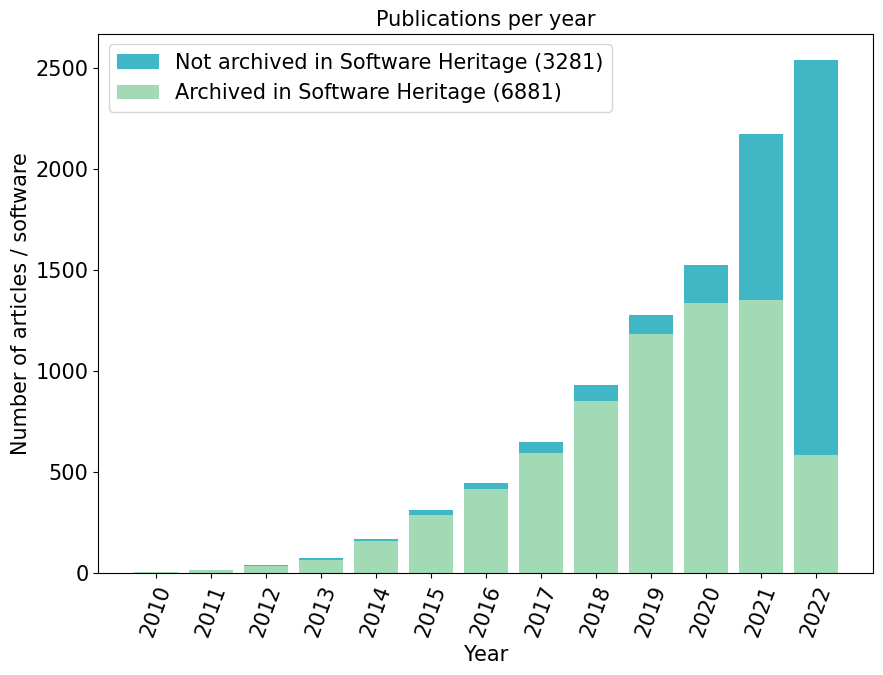

In [6]:
plt.rcParams["text.usetex"] = False
fig, ax = plt.subplots(figsize=(10, 7))

ax.bar(archive_dist.index, archive_dist["total"], color="#41b6c4")
ax.bar(archive_dist.index, archive_dist["archived"], color="#a1dab4")

ax.set_xlabel("Year", fontsize=15, fontfamily='sans-serif')
ax.set_ylabel("Number of articles / software", fontsize=15, fontfamily='sans-serif')
ax.set_title("Publications per year", fontsize=15, fontfamily='sans-serif')
ax.legend([
    f"Not archived in Software Heritage ({sum(archive_dist['total'] - archive_dist['archived'])})",
    f"Archived in Software Heritage ({sum(archive_dist['archived'])})"
    ],fontsize=15
)
plt.xticks(archive_dist.index, rotation=70)
ax.tick_params(axis="y", labelsize=15) 
ax.tick_params(axis="x", labelsize=15) 

plt.savefig("../results/stats_swh.png")
plt.show()

## Plot the timeline of software development (Fig.2)

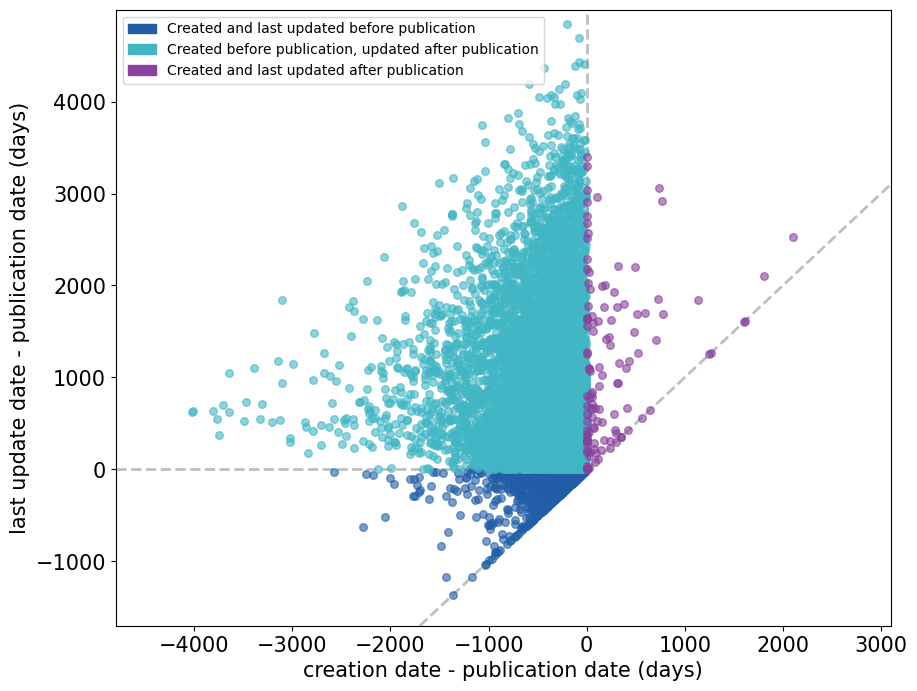

In [7]:
plt.rcParams["text.usetex"] = False
color = [0] * len(df)
alpha = [0] * len(df)

for index, row in enumerate(df["time_creation_to_publication"]):
    if row < 0 and df["time_update_to_publication"].iloc[index] <= 0:
        color[index] = '#225ea8'
        alpha[index] = 0.6
    if row < 0 and df["time_update_to_publication"].iloc[index] > 0:
        color[index] = '#41b6c4'
        alpha[index] = 0.6
    if row >= 0:
        color[index] = '#88419d'
        alpha[index] = 0.6

fig, ax = plt.subplots(figsize=(10, 8))

# Plot articles with repo created before publication and updated before publication
df_tmp = (df
  .query("time_creation_to_publication < 0")
  .query("time_update_to_publication <= 0")
)
ax.scatter(df_tmp["time_creation_to_publication"], df_tmp["time_update_to_publication"],
           alpha=0.6, s=30, color="#225ea8")
created_before_updated_before = len(df_tmp)

# Plot articles with repo created before publication and updated after publication
df_tmp = (df
  .query("time_creation_to_publication < 0")
  .query("time_update_to_publication > 0")
)
ax.scatter(df_tmp["time_creation_to_publication"], df_tmp["time_update_to_publication"],
           alpha=0.6, s=30, color="#41b6c4")
created_before_updated_after = len(df_tmp)

# Plot articles with repo created before publication and updated after publication
df_tmp = (df
  .query("time_creation_to_publication >= 0")
)
ax.scatter(df_tmp["time_creation_to_publication"], df_tmp["time_update_to_publication"],
           alpha=0.6, s=30, color="#88419d")
created_after_updated_after = len(df_tmp)

# Plot publication date lines
ax.axvline(x=0, ymin=0.26, ymax=1, color="gray", linestyle="--", linewidth=2, alpha=0.5, zorder=0)  
ax.axhline(y=0, xmin=0, xmax=0.6, color="gray", linestyle="--", linewidth=2, alpha=0.5, zorder=0)
# Plot creation date = udpdate date line
ax.axline((0, 0), (1, 1), color="gray", linestyle="--", linewidth=2, alpha=0.5, zorder=0)

ax.set_xlabel("creation date - publication date (days)", fontdict={"fontsize": 15, "fontfamily": "sans-serif"})
ax.set_ylabel("last update date - publication date (days)", fontdict={"fontsize": 15, "fontfamily": "sans-serif"})

ax.set_xlim([-4800, 3100])
ax.set_ylim([-1700, 4999])

dblue_patch = mpatches.Patch(color="#225ea8", label="Created and last updated before publication")
lblue_patch = mpatches.Patch(color="#41b6c4", label="Created before publication, updated after publication")
green_patch = mpatches.Patch(color='#88419d', label="Created and last updated after publication")
patches = [dblue_patch, lblue_patch, green_patch]
ax.legend(handles=patches, loc="upper left")
ax.tick_params(axis="y", labelsize=15) 
ax.tick_params(axis="x", labelsize=15) 

plt.savefig("../results/development_dynamic.png")
plt.show()

## Plot the quantification of the fig. 2 (Fig. 3)

Number of articles / software: 10176


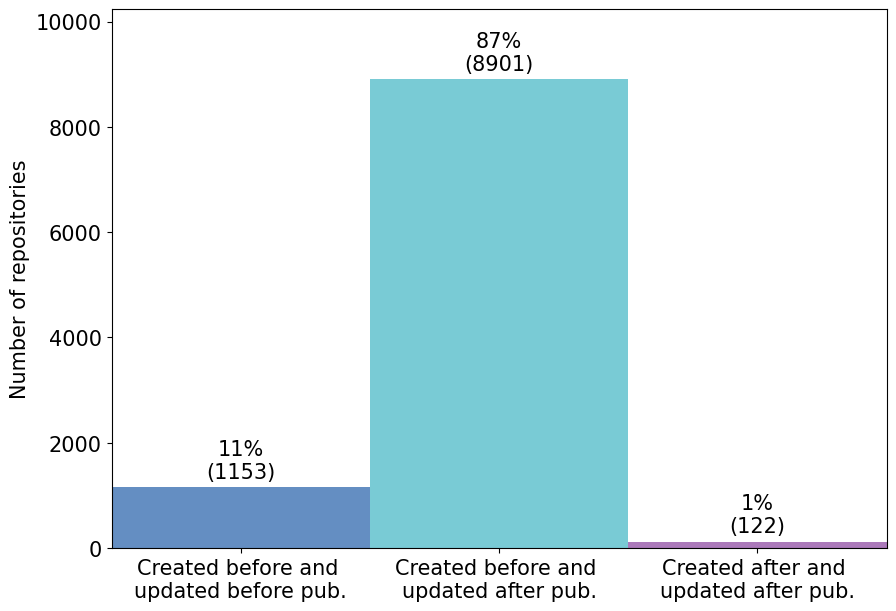

In [8]:
plt.rcParams["text.usetex"] = False

fig, ax = plt.subplots(figsize=(10, 7))

counts = (created_before_updated_before, created_before_updated_after, created_after_updated_after)
print(f"Number of articles / software: {sum(counts)}")

edges = [0.5, 1.5, 2.5]
labels = (
    "Created before and \nupdated before pub.",
    "Created before and \nupdated after pub.",
    "Created after and \nupdated after pub."
)
color = ("#225ea8", "#41b6c4", "#88419d")
ax.bar(edges, counts, width=1, color=color, alpha=0.7)
ax.set_xlim(0, 3)
ax.set_xticks(edges, labels, fontsize=15, fontfamily="sans-serif")

for index, value in enumerate(counts):
    ax.text(index+0.5, value+100, f"{100*value/sum(counts):.0f}%\n({value})",
            ha="center", va="bottom", fontdict={"fontsize": 15, "fontfamily": "sans-serif"})

ax.set_ylim([0, max(counts)*1.15])
ax.set_ylabel("Number of repositories", fontdict={"fontsize": 15, "fontfamily": "sans-serif"})
ax.tick_params(axis="y", labelsize=15) 

plt.savefig("../results/development_hist.png")
plt.show()

## Plot the projections of the fig. 2 (Fig. 4 a-c)

Bin width: 30 days


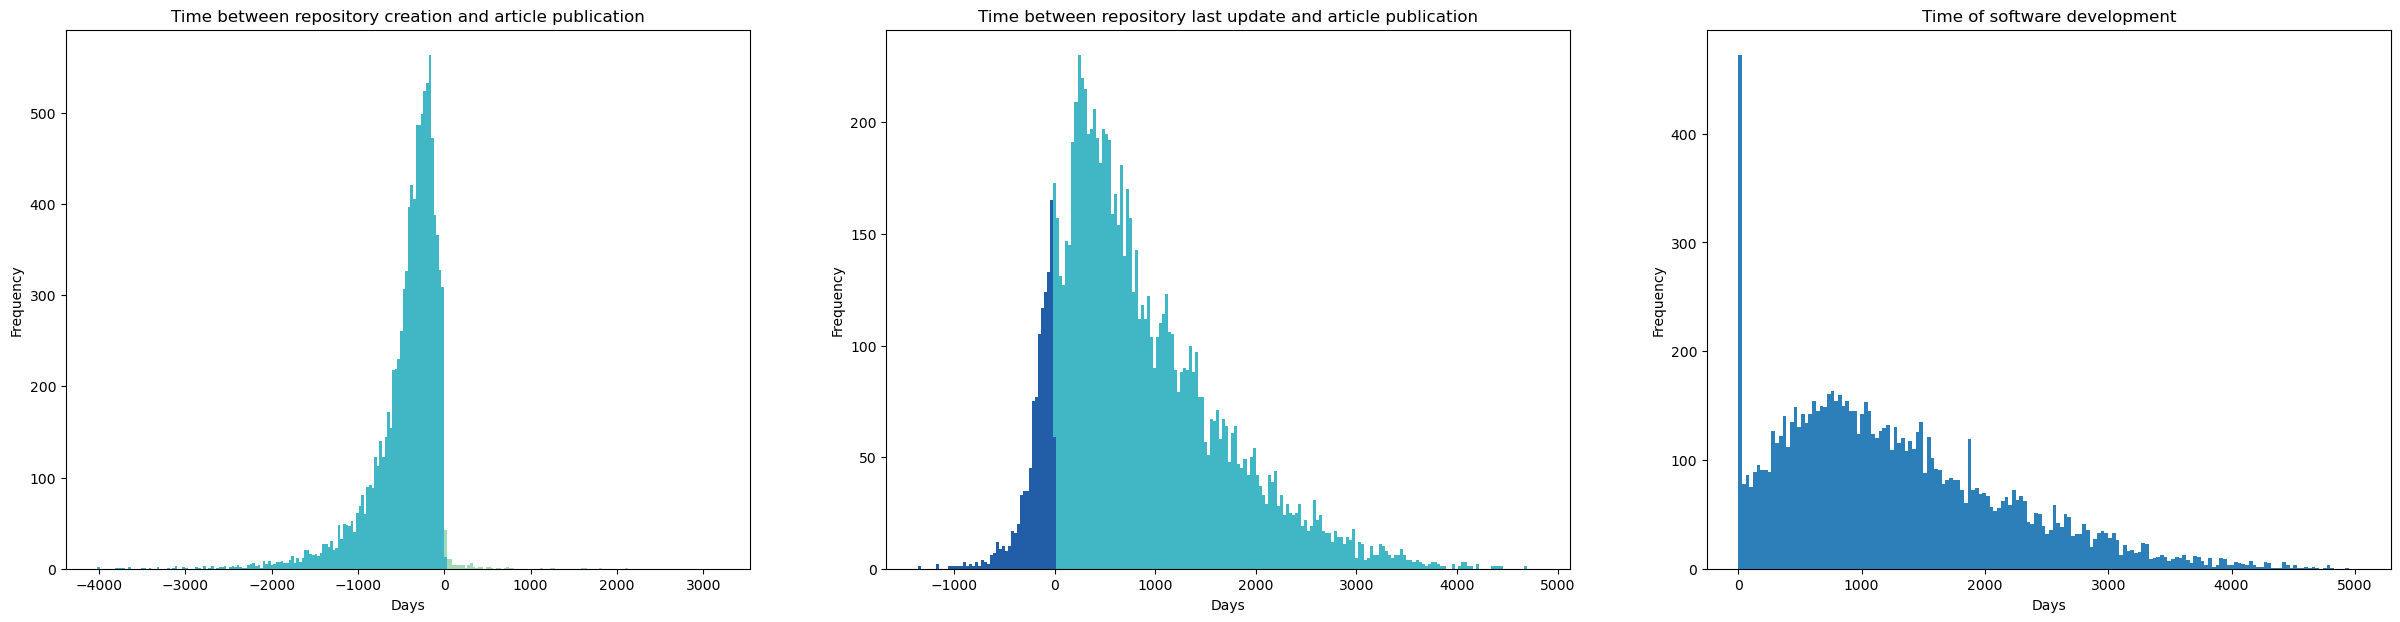

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(30, 7))

bin_width = 30  # 30 days
print(f"Bin width: {bin_width} days")

# Distribution of the time from creation to publication
bin_edges = np.arange(min(df["time_creation_to_publication"]), max(df["time_creation_to_publication"]), bin_width)
axs[0].hist(df[df['time_creation_to_publication']>=0]['time_creation_to_publication'], bins=bin_edges, color="#a1dab4")
axs[0].hist(df[df['time_creation_to_publication']<0]['time_creation_to_publication'], bins=bin_edges, color="#41b6c4")
axs[0].set_xlabel("Days")
axs[0].set_ylabel("Frequency")
axs[0].set_title("Time between repository creation and article publication")

# Distribution of the time from publication to the last update
bin_edges = np.arange(min(df["time_update_to_publication"]), max(df["time_update_to_publication"]), bin_width)
axs[1].hist(df[df['time_update_to_publication']>=0]['time_update_to_publication'], bins=bin_edges, color="#41b6c4")
axs[1].hist(df[df['time_update_to_publication']<0]['time_update_to_publication'], bins=bin_edges, color="#225ea8")
axs[1].set_xlabel("Days")
axs[1].set_ylabel("Frequency")
axs[1].set_title("Time between repository last update and article publication")

# Distribution of the development time
df["dev_time"] = (df["date_repo_updated"] - df["date_repo_created"]).dt.days
bin_edges = np.arange(min(df["dev_time"]), max(df["dev_time"]), bin_width)
axs[2].hist(df["dev_time"],
            bins=bin_edges, color="#2c7fb8")
axs[2].set_xlabel("Days")
axs[2].set_ylabel("Frequency")
axs[2].set_title("Time of software development")

plt.savefig("../results/development_time.png")
plt.show()

## Plot the fig. 5b in a larger format (Fig. 5)

Bin width: 30 days


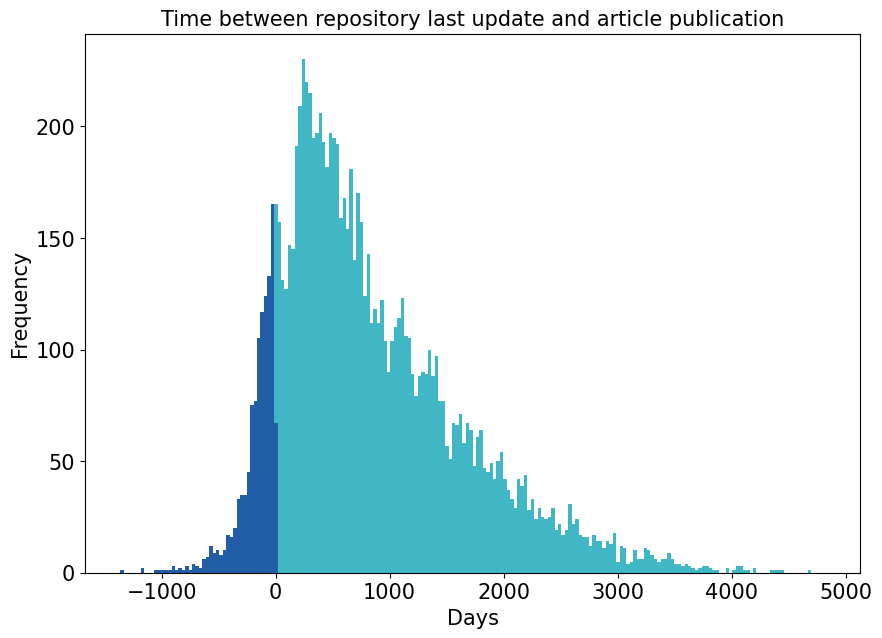

In [10]:
fig, axs = plt.subplots(figsize=(10, 7))

bin_width = 30  # 30 days
print(f"Bin width: {bin_width} days")
bin_edges = np.arange(min(df["time_update_to_publication"]), max(df["time_update_to_publication"]), bin_width)

axs.hist(df[df["time_update_to_publication"]>0]['time_update_to_publication'], bins=bin_edges, color="#41b6c4")
axs.hist(df[df["time_update_to_publication"]<=0]['time_update_to_publication'], bins=bin_edges, color="#225ea8")

axs.set_xlabel("Days", fontsize=15, fontfamily="sans-serif")
axs.set_ylabel("Frequency", fontsize=15, fontfamily="sans-serif")
axs.set_title("Time between repository last update and article publication", fontsize=15, fontfamily="sans-serif")
axs.tick_params(axis="y", labelsize=15) 
axs.tick_params(axis="x", labelsize=15) 

plt.savefig("../results/stat_last_update.png")
plt.show()